# MixMod Tutorial

Welcome to the MixMod tutorial! Here we'll go over the basic functionality of MixMod. It's a small package, so the explanation of the MixtureModel class will be brief and will largely focus on formatting the inputs correctly. (Mixture models are relatively parameter-rich, so the syntax for properly specifying all the components can be a little verbose!) The first portion of this tutorial is a brief introduction to mixture models, their use cases, and why parameter inference is a hard problem, so feel free to skip to the MixMod Class section if you're already familiar with mixture model theory.

## 1 Mixture Model Theory

### 1.1 What are mixture models and what are they good for?

Unlike in introductory statistics courses where the data are typically clean examples of a single distribution, real data are messy. They contain outliers, missing values, and may represent the result of multiple overlapping random processes. One common example is a "bimodal" distribution of exam scores where there are two groups of students, those who understood the material and those who didn't. As an instructor, we'll likely want to calculate the means within groups and give students different instruction depending on whether we think they understood the previous material. In other words, we want to 1) understand the statistical properties of each group and 2) assign observations to these groups. More formally, these two goals are parameter estimation and class inference, and they are the major applications of mixture models. If the observations were labeled with their classes, these calculations would be trivial. The challenge is class labels are typically hidden in real-world data, so the observations from different classes are jumbled together. In most cases, class labels don't even exist since the mixture model is a statistical formalism rather than an accurate representation of the underlying data generation process. (This idea that statistical models which fall short of fully describing reality can still provide valuable insights is commonly expressed as the adage "All models are wrong, but some are useful.")

### 1.2 A formal definition

Let's now give a more formal definition of mixture models (which is adapted from [Wikipedia](https://en.wikipedia.org/wiki/Mixture_model)). A mixture model consists of the following components:

- A set of *K* mixture components, each of which is a probability distribution.
- A set of *K* parameters, each specifying the parameters of its corresponding mixture component. In many cases, each "parameter" is actually a set of parameters. For example, if the mixture components are normal distributions, each component will have a mean and variance.
- A set of *K* mixture weights, which are probabilities that sum to 1.

The probability density function for a mixture model evaluated at $x_i$ is given by:

$$ f(x_i) = \sum_{k=1}^K \phi_k f_k(x_i; \theta_k) $$

where $K$ is number of components, $\phi_k$ is the weight, $f_k$ is the pdf, and $\theta_k$ is the parameter set of each component.



The above equation applies to a mixture model for an observation with an unknown class label. If the class label, $z_i$, is known, then the density function is given by:

$$ f(x_i) = \sum_{k=1}^K \delta_{kz_i} \phi_k f_k(x_i; \theta_k) $$

where $\delta_{ij}$ is the Kronecker delta function.


Since $\delta_{ij} = 0$ when $i \ne j$, this equation reduces to the distribution corresponding to the class of the observation.

### 1.3 Fitting mixture models

If the class labels are known, then some algebra using the above equation will show the overall likelihood for the data is maximized when the component likelihoods are maximized for the data corresponding to that component. This checks out intuitively. If we knew the class labels, then we could treat the components separately and choose the best parameters for each using only the observations from that component.

When the class labels are not known, parameter inference is a different beast entirely. The problem is a little like a chicken or egg question. If we knew the class labels, then we could easily infer the component parameters. If we knew the component parameters, then we could infer the class labels (and in turn use those labels to infer the component parameters). This is very nearly estimation-maximization (EM), the algorithm that yields parameter estimates for statistical models with unobserved variables (like the class labels in mixture models). The basic idea is by alternating between assigning class labels to observations using the current parameter estimates and then using those class assignments to update the parameters, the parameters will eventually converge to a local maximum of the likelihood function. The actual procedure is a little more subtle than making hard class assignments for each observation, but the basic idea is very similar.

The EM algorithm is highly flexible, so it is possible to implement the procedure for a generic mixture model. However, such an implementation would necessarily rely on general purpose numerical optimization routines, which can be somewhat finicky to use in practice. Thus, for both efficiency and robustness, this package limits the distributions to those where the EM equations are explicitly solved. More details are available in the section "Creating mixtures of other distributions."

## 2 The MixtureModel Class

### 2.1 Importing the package and generating data

With all that out of the way, let's introduce the MixMod package! First we need to import it and some supporting libraries.

In [1]:
import matplotlib.pyplot as plt
import mixmod
import numpy as np
import scipy.stats as stats

Now let's generate some data. We'll start with a simple mixture of two normal distributions. In the SciPy stats implementation, the mean and standard deviation are specified with the `loc` and `scale` parameters, respectively. This is standard practice within this module as well as in statistics more broadly. Distributions are often characterized by different, but related, parameters depending on the context. However, most of these can be expressed in a standard form as either a location or scale parameter. Location parameters shift the position of the distribution whereas scale parameters control the spread. Both of these have formal mathematical definitions which define these ideas precisely. The practical take-away, however, is the SciPy implementations of distributions express all location and scale parameters in their standard forms. These forms may differ from the conventional parametrizations, so be sure to read the documentation for each distribution thoroughly.

In [2]:
rvs0 = stats.norm.rvs(loc=1, scale=1.25, size=400, random_state=1)
rvs1 = stats.norm.rvs(loc=5, scale=0.75, size=100, random_state=2)
rvs = np.concatenate([rvs0, rvs1])

We can visualize these distributions separately. We'll manually set the bins, so the two histograms are drawn on the same intervals.

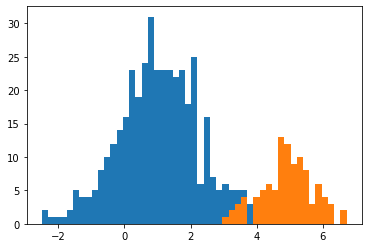

In [3]:
bins = np.linspace(rvs.min(), rvs.max(), num=50)
plt.hist(rvs0, bins=bins, color='C0')
plt.hist(rvs1, bins=bins, color='C1');

Usually, however, the observations from the two components are mixed together.

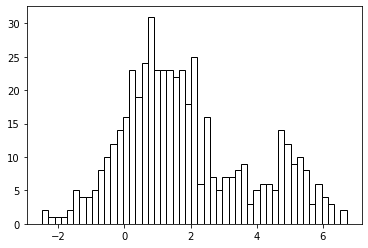

In [4]:
plt.hist(rvs, bins=bins, facecolor='white', edgecolor='black');

Clearly the overall distribution is bimodal, but the division between the two components isn't immediately obvious, even in a simple case like this. Let's now use a `MixtureModel` to try to extract the parameters.

### 2.2 Instantiating a MixtureModel and plotting its pdf

The easiest way of instantiating a `MixtureModel` is by simply passing a list of SciPy stats distributions.

In [5]:
mixture = mixmod.MixtureModel([stats.norm, stats.norm])
mixture

MixtureModel(components=['norm', 'norm'],
             params=[{}, {}],
             params_fix=[{}, {}],
             weights=[0.5, 0.5],
             name='mixture')

This is the minimal amount of information needed, so most of the attributes of the instance are currently empty. Notice, however, the weights were set uniformly across components by default. Let's now make this mixture model more interesting by giving it some better initial parameters. It's not necessary to specify all the parameters for each component. Any parameters not defined in the `params` or `params_fix` dicts will use the default values specified by the distribution.

In [6]:
mixture = mixmod.MixtureModel([stats.norm, stats.norm],
                              params=[{'loc': 1}, {'loc': 5}],
                              weights=[0.6, 0.4])
mixture

MixtureModel(components=['norm', 'norm'],
             params=[{'loc': 1}, {'loc': 5}],
             params_fix=[{}, {}],
             weights=[0.6, 0.4],
             name='mixture')

Let's look at how well the density function matches the histogram.

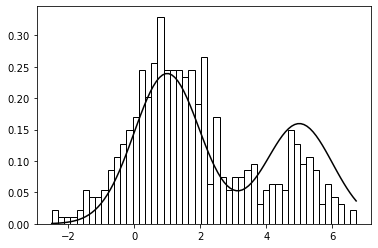

In [7]:
x = np.linspace(rvs.min(), rvs.max(), 100)
y = mixture.pdf(x)

plt.hist(rvs, bins=bins, density=True, facecolor='white', edgecolor='black')
plt.plot(x, y, color='black');

We can also extract the pdfs of the individual components and plot them separately.

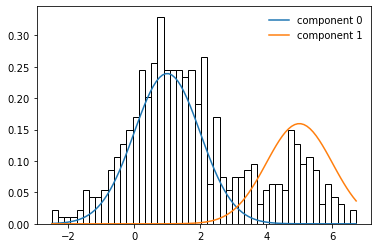

In [8]:
x = np.linspace(rvs.min(), rvs.max(), 100)
y = mixture.pdf(x, component='all')

plt.hist(rvs, bins=bins, density=True, facecolor='white', edgecolor='black')
plt.plot(x, y[0], label='component 0', color='C0')
plt.plot(x, y[1], label='component 1', color='C1')
plt.legend(frameon=False);

### 2.3 Fitting a MixtureModel

Our initial parameters aren't bad, but let's see if we can do a little better. We'll call `fit` on our data to optimize the parameters.

In [9]:
mixture.fit(rvs)
mixture

MixtureModel(components=['norm', 'norm'],
             params=[{'loc': 1.075064120193221, 'scale': 1.2297761836368324}, {'loc': 4.951025549835546, 'scale': 0.7512261603391855}],
             params_fix=[{}, {}],
             weights=[0.8038979521998084, 0.19610204780019164],
             name='mixture')

These new parameters look closer to their true values. You can also see each component has a `scale` parameter in its `params` dict now since they are now estimated from the data and not using the default values. Let's see if the pdfs match the histograms better.

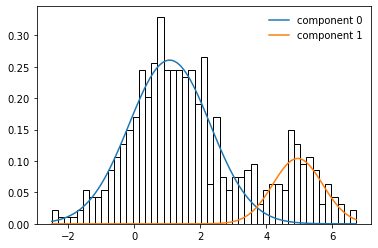

In [10]:
x = np.linspace(rvs.min(), rvs.max(), 100)
y = mixture.pdf(x, component='all')

plt.hist(rvs, bins=bins, density=True, facecolor='white', edgecolor='black')
plt.plot(x, y[0], label='component 0', color='C0')
plt.plot(x, y[1], label='component 1', color='C1')
plt.legend(frameon=False);

### 2.4 Fitting a MixtureModel with fixed parameters

One downside of this approach is all the parameters associated with each component are fit to the data. In some cases, we might have existing estimates for certain parameters that we want to stay constant. We can communicate this information to a `MixtureModel` by passing these parameters in the `params_fix` dicts. For example, let's say we're confident the `loc` parameter of the second component is 5, but we're unsure about the remaining parameters.

In [11]:
mixture = mixmod.MixtureModel([stats.norm, stats.norm],
                              params_fix=[{}, {'loc': 5}])
mixture

MixtureModel(components=['norm', 'norm'],
             params=[{}, {}],
             params_fix=[{}, {'loc': 5}],
             weights=[0.5, 0.5],
             name='mixture')

Notice that an empty dict is supplied for the first component, so the correspondence between components and dicts is unambiguous.

When we plot the pdfs of the components, we can see they use their default parameters (`loc=1`, `scale=1`) for any parameters not given in `params` or `params_fix`.

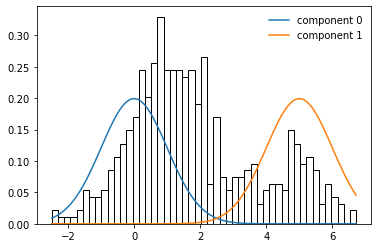

In [12]:
x = np.linspace(rvs.min(), rvs.max(), 100)
y = mixture.pdf(x, component='all')

plt.hist(rvs, bins=bins, density=True, facecolor='white', edgecolor='black')
plt.plot(x, y[0], label='component 0', color='C0')
plt.plot(x, y[1], label='component 1', color='C1')
plt.legend(frameon=False);

Now let's fit the free parameters.

In [13]:
mixture.fit(rvs)
mixture

MixtureModel(components=['norm', 'norm'],
             params=[{'loc': 1.0902243856040947, 'scale': 1.2426261846440032}, {'scale': 0.7284102181034722}],
             params_fix=[{}, {'loc': 5}],
             weights=[0.8086240293915813, 0.19137597060841857],
             name='mixture')

As expected, the `loc` parameter of the second component has remained fixed at 5.

### 2.5 Predicting class labels

We'll now address the second major task of mixture models: inference of class labels. The `posterior` method returns a distribution across components for each observation.

In [14]:
posterior = mixture.posterior(rvs)
posterior.shape

(2, 500)

Let's look at an individual observation and its posterior distribution.

In [15]:
print(rvs[0])
print(posterior[:, 0])

3.030431704579052
[0.96589593 0.03410407]


This isn't the most intuitive way of visualizing the output, so we'll plot it a few different ways.

We can first plot the posterior probability of a class by its position along the x-axis as a line graph.

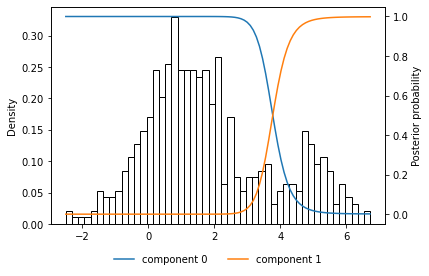

In [16]:
x = np.linspace(rvs.min(), rvs.max(), 100)
y = mixture.posterior(x)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.hist(rvs, bins=bins, density=True, facecolor='white', edgecolor='black')
ax2.plot(x, y[0], color='C0', label='component 0')
ax2.plot(x, y[1], color='C1', label='component 1')
ax1.set_ylabel('Density')
ax2.set_ylabel('Posterior probability')
ax2.legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False);

We can plot the same information as a heatmap.

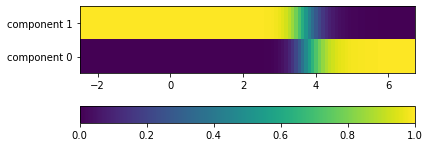

In [17]:
aspect = 0.2  # Ratio of y-axis to x-axis in display units

plt.imshow(y, vmin=0, vmax=1,
           aspect=aspect*(x.max() - x.min()) / y.shape[0],
           extent=[x.min(), x.max(), 0, y.shape[0]])
plt.yticks([y + 0.5 for y in range(y.shape[0])], [f'component {y}' for y in range(y.shape[0])])
plt.colorbar(location='bottom', orientation='horizontal');

### 2.6 Creating mixtures of other distributions

Obviously this package wouldn't be very useful if it was limited to fitting mixture models with only two normal components. Fortunately, it can fit an arbitrary number of components. Unfortunately, these components are limited to a relatively small subset of the distributions defined in SciPy stats, as the EM equations are explicitly solved for these distributions. This makes fitting the parameters more efficient and robust than if general purpose numerical optimization algorithms were used. The cost, however, is the types of distributions available are somewhat limited.

We can view the supported distributions by examining the `mles` variable in `mixmod.estimators`. It stores the maximum-likelihood estimators for each distribution in a dictionary.

In [18]:
mixmod.estimators.mles.keys()

dict_keys(['binom', 'discrete', 'expon', 'fisk', 'gamma', 'geom', 'laplace', 'levy', 'lognorm', 'norm', 'pareto', 'poisson', 'uniform'])

Let's now simulate a mixture of exponential, gamma, and normal components and fit a mixture model!

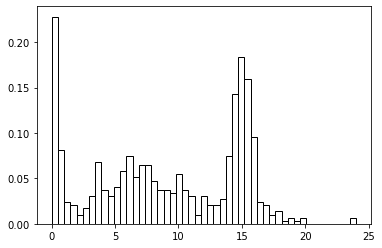

In [19]:
rvs0 = stats.expon.rvs(scale=0.5, size=100, random_state=3)
rvs1 = stats.gamma.rvs(a=4, scale=2, size=300, random_state=4)
rvs2 = stats.norm.rvs(loc=15, scale=0.75, size=200, random_state=5)
rvs = np.concatenate([rvs0, rvs1, rvs2])

bins = np.linspace(rvs.min(), rvs.max(), num=50)
plt.hist(rvs, bins=bins, density=True, facecolor='white', edgecolor='black');

In [20]:
mixture = mixmod.MixtureModel([stats.expon, stats.gamma, stats.norm])
mixture

MixtureModel(components=['expon', 'gamma', 'norm'],
             params=[{}, {}, {}],
             params_fix=[{}, {}, {}],
             weights=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333],
             name='mixture')

In [21]:
mixture.fit(rvs)
mixture

MixtureModel(components=['expon', 'gamma', 'norm'],
             params=[{'scale': 0.44291670356859164}, {'a': 4.179141304968203, 'scale': 2.028108317513398}, {'loc': 15.062120832507192, 'scale': 0.6838831528916532}],
             params_fix=[{}, {}, {}],
             weights=[0.16719136622829345, 0.520828275024613, 0.3119803587470935],
             name='mixture')

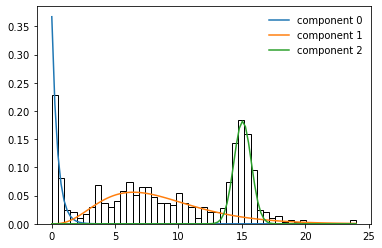

In [22]:
x = np.linspace(rvs.min(), rvs.max(), 100)
y = mixture.pdf(x, component='all')

plt.hist(rvs, bins=bins, density=True, facecolor='white', edgecolor='black')
plt.plot(x, y[0], label='component 0', color='C0')
plt.plot(x, y[1], label='component 1', color='C1')
plt.plot(x, y[2], label='component 2', color='C2')
plt.legend(frameon=False);

### 2.7 Fitting a zero-inflated discrete MixtureModel

Although we've only seen examples of continuous distributions so far, MixMod also supports a number of discrete distributions, including the binomial, Poisson, and geometric distributions. A common application of discrete mixture models is fitting zero-inflated data, *i.e.*, data with an "excess" number of zeros. In these cases, the data is often the result of two distinct processes. The first is whatever is creating the "distribution" over many values, and the second is something that only generates values of zero. A more concrete (and non-serious) example is the number of colds each person in population catches in year. Most people catch a handful of colds, but some lucky fraction, as a result of either fastidious hygeine or superior genetics, never seem to get sick.

Let's model this scenario with a combination of a "zero" and a Poisson distribution. We'll exaggerate the parameters to make the contribution of the "zero" process obvious.

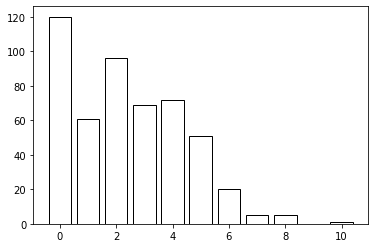

In [23]:
rvs0 = np.zeros(100)
rvs1 = stats.poisson.rvs(mu=3, size=400, random_state=6)
rvs = np.concatenate([rvs0, rvs1])

x, h = np.unique(rvs, return_counts=True)
plt.bar(x, h, facecolor='white', edgecolor='black');

To fit a model to this data, we'll create a MixtureModel instance with the desired components as in previous examples. Unfortunately, SciPy doesn't have an implementation of a "zero" distribution, and its implementation of a generic discrete random variable isn't flexible enough for our needs. Thus, we'll have to implement a custom distribution. Fortunately, this is straightforward since we only have to write a `pmf` and `cdf` method. The estimators for this distribution are already available in MixMod, so our implementation will have to match its names for the distribution (`'discrete'`) and parameters (`xs` and `ps`). The code itself is a direct translation of the mathematical definitions of these functions. It only looks a little complicated because it's conforming to SciPy's convention for returning ndarrays by default unless the input is explicitly a "raw" number.

In [24]:
class discrete_gen:
    def __init__(self, name):
        self.name = name
        
    def pmf(self, k, xs, ps):
        k = np.asarray(k)
        output = np.zeros(k.shape)
        for x, p in zip(xs, ps):
            output[k == x] = p
        if output.ndim == 0:
            return output[()]
        return output
    
    def cdf(self, k, xs, ps):
        k = np.asarray(k)
        output = np.zeros(k.shape)
        for x, p in zip(xs, ps):
            output += p * (x <= k)
        if output.ndim == 0:
            return output[()]
        return output
discrete = discrete_gen(name='discrete')

Now we're ready to instantiate and fit the model. The "zero" component is an instance of the discrete distribution we just defined where `xs` contains a single zero. We pass this as a fixed parameter, so the `fit` method knows which observations can contribute to the component. (An error is raised if a discrete distribution is given as a component without a corresponding fixed `xs`.)

In [25]:
mixture = mixmod.MixtureModel([discrete, stats.poisson],
                              params_fix=[{'xs': [0]}, {}])
mixture

MixtureModel(components=['discrete', 'poisson'],
             params=[{}, {}],
             params_fix=[{'xs': [0]}, {}],
             weights=[0.5, 0.5],
             name='mixture')

In [26]:
mixture.fit(rvs)
mixture

MixtureModel(components=['discrete', 'poisson'],
             params=[{'ps': [1.0]}, {'mu': 3.024078290102476}],
             params_fix=[{'xs': [0]}, {}],
             weights=[0.20107888479364402, 0.7989211152063559],
             name='mixture')

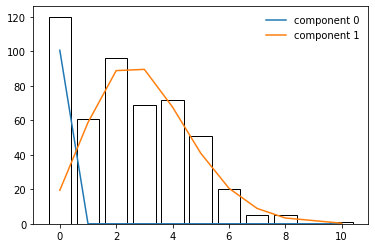

In [27]:
y = mixture.pmf(x, component='all') * h.sum()  # Scale pmf by total number of observations

plt.bar(x, h, facecolor='white', edgecolor='black')
plt.plot(x, y[0], label='component 0', color='C0')
plt.plot(x, y[1], label='component 1', color='C1')
plt.legend(frameon=False);

The fit looks good! For comparison, though, let's calculate the Poisson parameter if we didn't account for the "zero" component at all ("naive estimation"), if we dropped the zeros from the data ("zero-drop estimation"), and if we knew the labels exactly ("omniscient estimation").

In [28]:
print('Naive estimation: ', rvs.mean())
print('Zero-drop estimation: ', rvs[rvs != 0].mean())
print('Omniscient estimation: ', rvs1.mean())
print('MixMod estimation: ', mixture.params[1]['mu'])

Naive estimation:  2.416
Zero-drop estimation:  3.1789473684210527
Omniscient estimation:  3.02
MixMod estimation:  3.024078290102476


The naive method is too low because the excess zeros are bringing the average down, but the zero-drop method is too high because we're excluding some zeros which were generated by the Poisson component. The MixMod estimate, however, is just right!

While we originally motivated this example by fitting a constant "zero" component, the strength of this implementation  is it is easily extended to an arbitrary discrete distribution. Try modifying it to fit a "zero and one inflated" Poisson model!

## 3 Conclusion

This brings us to the conclusion of the tutorial. We've covered the major parts of the `MixtureModel` class. There are a few optional arguments and methods we haven't touched on here, but they are straightforward and explained fully in the formal documentation. If you have any questions, please don't hesitate to reach out!